### 해당 파일은 **랜덤한 k명 연예인의 임베딩 벡터**를 시각화해주는 코드입니다.</br>사용자가 변수값을 입력해줘야 하는 부분은 **0. 변수설정**입니다.

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import random
import math
import cv2

from sklearn.manifold import TSNE

workers = 0 if os.name == 'nt' else 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


### 0. 변수설정

In [2]:
# data_path: 연예인 폴더들을 포함하는 상위 폴더
data_path = "/opt/ml/facenet_pytorch/data/actor_data"

# k: k명의 연예인 임베딩 벡터를 시각화할 예정
k = 10

### 1. MTCNN 모듈 및 InceptionResnetV1 모듈 정의

In [3]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [4]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

### 2. 랜덤한 k명의 연예인 선택

In [5]:
# 사진이 없는 경우 해당 폴더는 crop대상에서 제외
actor_names = []
remove_names = []
for actor_name in os.listdir(data_path):
    file_path = os.path.join(data_path, actor_name)
    if os.path.isdir(file_path):
        if len(os.listdir(file_path)) > 0: # 해당 폴더에 사진이 있는 경우
            actor_names.append(actor_name)
        else:
            remove_names.append(actor_name)

print(f'사진이 존재하는 배우: {len(actor_names)}명') # 818명
print(f'사진이 존재하지 않는 배우(삭제될 배우): {len(remove_names)}명') # 5명

사진이 존재하는 배우: 818명
사진이 존재하지 않는 배우(삭제될 배우): 5명


In [6]:
select_names = random.sample(actor_names, k)
print(f'랜덤 {k}명의 배우:\n{select_names}')

랜덤 10명의 배우:
['채영인', '이진욱', '김성수', '한지완', '이종석', '음문석', '오지호', '장원영', '조여정', '고아성']


### 3. Crop을 위한 custom Dataset정의 및 Data로드

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, data_path, select_names):
        self.mtcnn = mtcnn
        self.imgs, self.paths, self.labels, self.idx_to_class = self.make_dataset(data_path, select_names)
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        path = self.paths[idx]
        label = self.labels[idx]
        return img, path, label

    def make_dataset(self, data_path, select_names):
        imgs = []
        paths = []
        labels = []
        idx_to_class = {key:name for key, name in enumerate(select_names)}
        for key, name in idx_to_class.items():
            actor_path = os.path.join(data_path, name)
            for img_name in os.listdir(actor_path):
                # img의 차원이 3이 아니거나, 채널의 개수가 3이 아닌 경우 제외
                img_path = os.path.join(actor_path, img_name)
                img = cv2.imread(img_path)
                if type(img) == np.ndarray and len(img.shape) == 3 and img.shape[2] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    imgs.append(img)
                    paths.append(img_path)
                    labels.append(key)

        return imgs, paths, labels, idx_to_class

In [8]:
# k명 data 실행속도: 0.9s
dataset = CustomImageDataset(data_path, select_names)

In [9]:
print(f'crop대상 이미지 개수: {len(dataset.imgs)}')
print(f'len(labels): {len(dataset.labels)}')
print(f'dataset.idx_to_class: {dataset.idx_to_class}')

crop대상 이미지 개수: 265
len(labels): 265
dataset.idx_to_class: {0: '채영인', 1: '이진욱', 2: '김성수', 3: '한지완', 4: '이종석', 5: '음문석', 6: '오지호', 7: '장원영', 8: '조여정', 9: '고아성'}


In [10]:
def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers, batch_size=1)

### 4. Crop 수행 및 수행결과 확인

In [11]:
# 265장 -> 10s
aligned = []
names = []
i=0
for x, _, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    
    if x_aligned is not None:
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

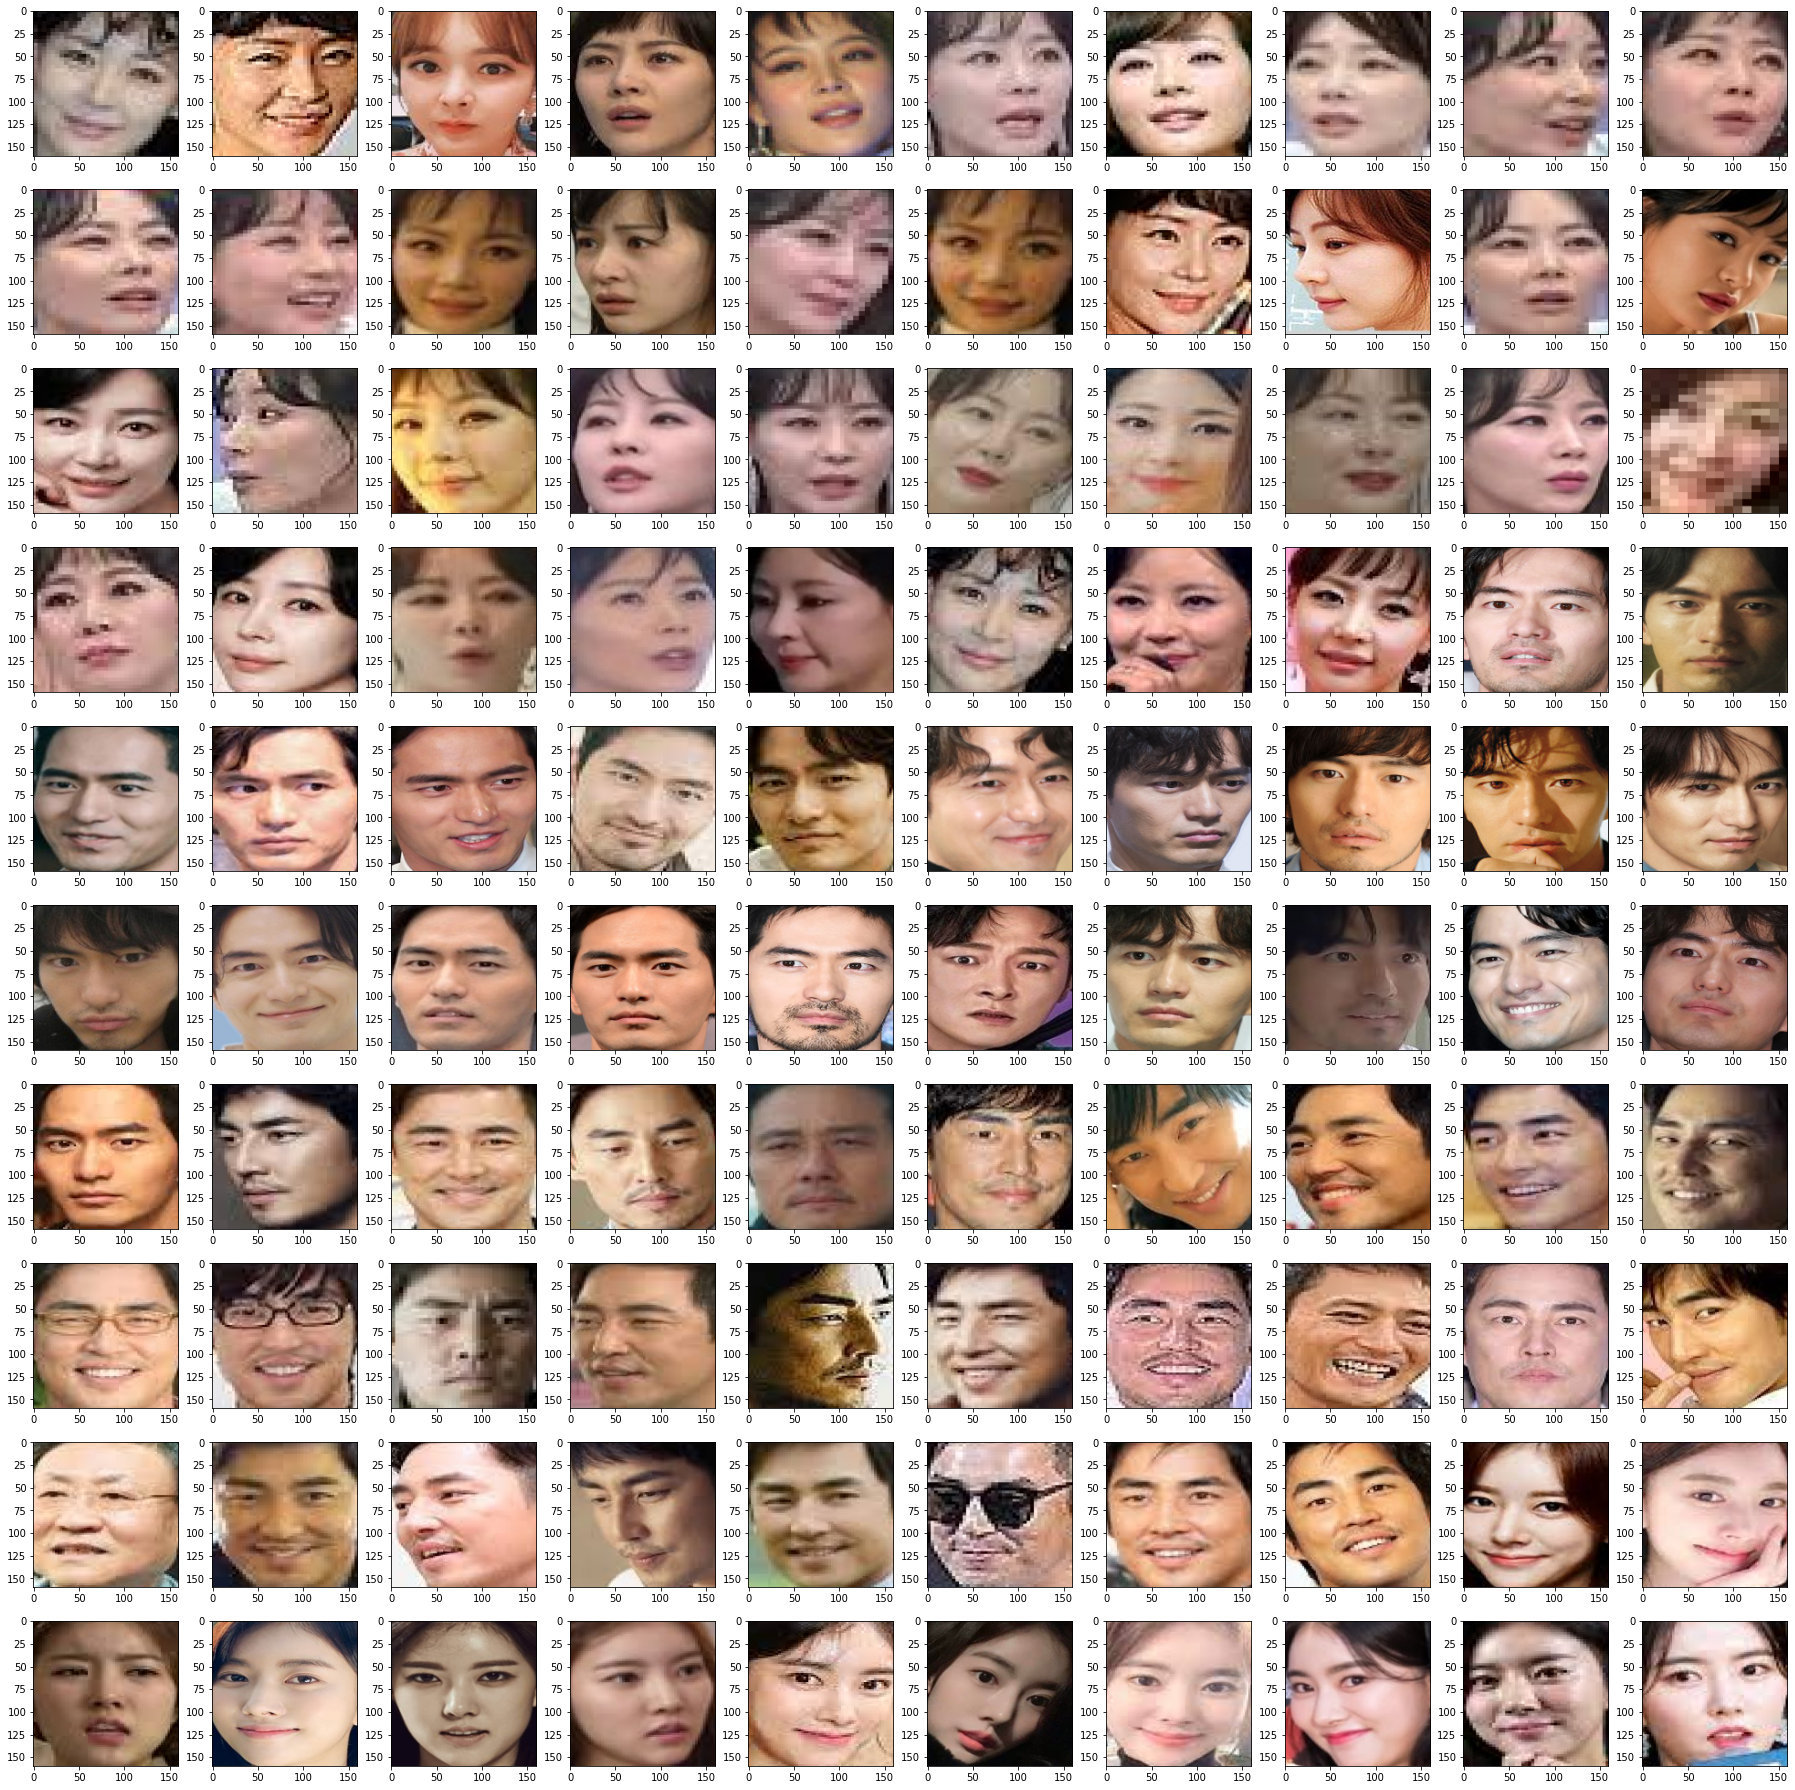

In [12]:
row_size = 10
col_size = min(10, math.ceil(len(aligned)//row_size))
fig, ax = plt.subplots(row_size, col_size, figsize=(25, 25)) 
for i, output in enumerate(aligned[:100]):
    ax[i//row_size][i%col_size].imshow((output * 128 + 127.5).cpu().numpy().astype(np.Uint64).transpose((1,2,0)))

fig.tight_layout()
plt.show()

### 5. Embedding vector 계산을 위한 Dataset정의 및 데이터로드

In [13]:
class EmbeddingDataset(Dataset):
    def __init__(self, aligned: list):
        aligned_torch = torch.stack(aligned)
        self.aligned_torch = aligned_torch

    def __len__(self):
        return len(self.aligned_torch)

    def __getitem__(self, idx):
        return self.aligned_torch[idx]

In [14]:
aligned_dataset = EmbeddingDataset(aligned)
alinged_loader = DataLoader(aligned_dataset, num_workers=workers, batch_size=50)

In [15]:
print(f'stack된 aligned shape: {aligned_dataset.aligned_torch.shape}')
print(f'len(aligned_dataset): {len(aligned_dataset)}') 
print(f'len(alinged_loader): {len(alinged_loader)}') 

stack된 aligned shape: torch.Size([265, 3, 160, 160])
len(aligned_dataset): 265
len(alinged_loader): 6


### 6. InceptionResnetV1 수행

In [16]:
# 265장 -> 0.5s
embeddings = []
for x in alinged_loader:
    y = resnet(x.to(device))
    embeddings.extend(y.detach().cpu().tolist())

In [17]:
print(f'embedding shape: {np.array(embeddings).shape}')

embedding shape: (265, 512)


### 7. TSNE로 embedding vector 차원 축소

In [18]:
# # 265장 -> 1.6s
tsne = TSNE(2, verbose=-1)
tsne_proj = tsne.fit_transform(np.array(embeddings))

/opt/conda/envs/final/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/final/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 265 samples in 0.000s...
[t-SNE] Computed neighbors for 265 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 265 / 265
[t-SNE] Mean sigma: 0.402531
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.680473
[t-SNE] KL divergence after 1000 iterations: 0.265300


### 8. 2차원으로 축소된 embedding vector 시각화

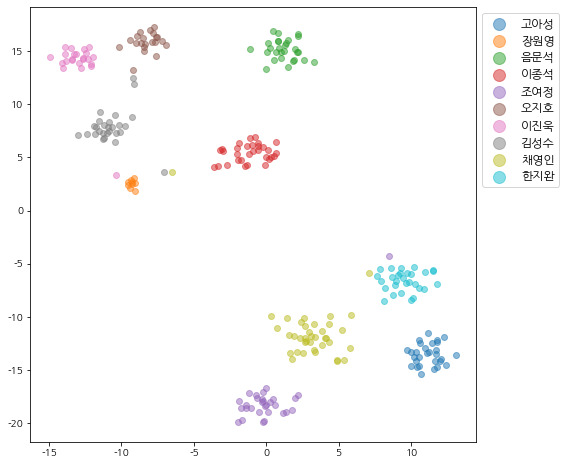

In [19]:
# 범례 한글 깨짐 현상 해결
# https://ehpub.co.kr/47-matplotlib%EC%9D%98-rc%EC%97%90-%ED%95%9C%EA%B8%80-%ED%8F%B0%ED%8A%B8%EB%A5%BC-%EC%84%A4%EC%A0%95%ED%95%A0-%EC%88%98-%EC%9E%88%EC%96%B4%EC%9A%94/
# https://koosco.tistory.com/38
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

num_categories = len(set(names))
cmap = matplotlib.cm.get_cmap('Set1', num_categories)

fig, ax = plt.subplots(figsize=(8,8))
for i,lab in enumerate(set(names)):
    indices = np.array(names)==lab
    # ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(i)).reshape(1,4), label = lab ,alpha=0.5)
    ax.scatter(tsne_proj[indices,0], tsne_proj[indices,1], cmap=cmap, label=lab ,alpha=0.5)


ax.legend(fontsize='large', markerscale=2, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()